<a href="https://colab.research.google.com/github/VeectorVt/predicao-engajamento/blob/main/Predi%C3%A7%C3%A3o_de_engajamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-48dcff413fe5>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['60_day_eng_rate'].fillna(data['60_day_eng_rate'].mean(), inplace=True)


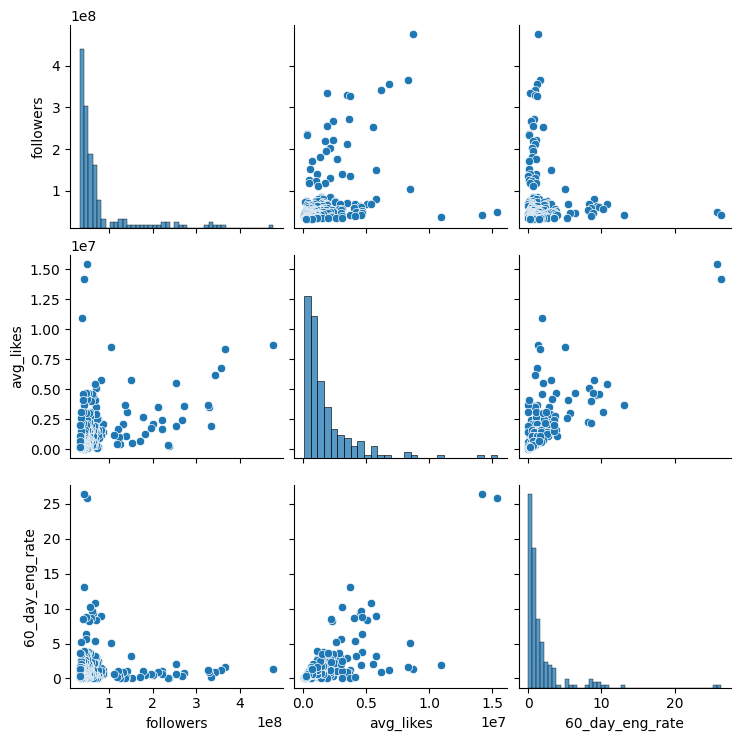

Modelo: SGDRegressor (Gradiente Descendente)

SGDRegressor (Gradiente Descendente)
R² Score: 0.9410
MSE: 0.3735
MAE: 0.4507

Coeficientes do modelo:
followers: -1.5611
avg_likes: 0.3246
new_post_avg_like: 3.0333


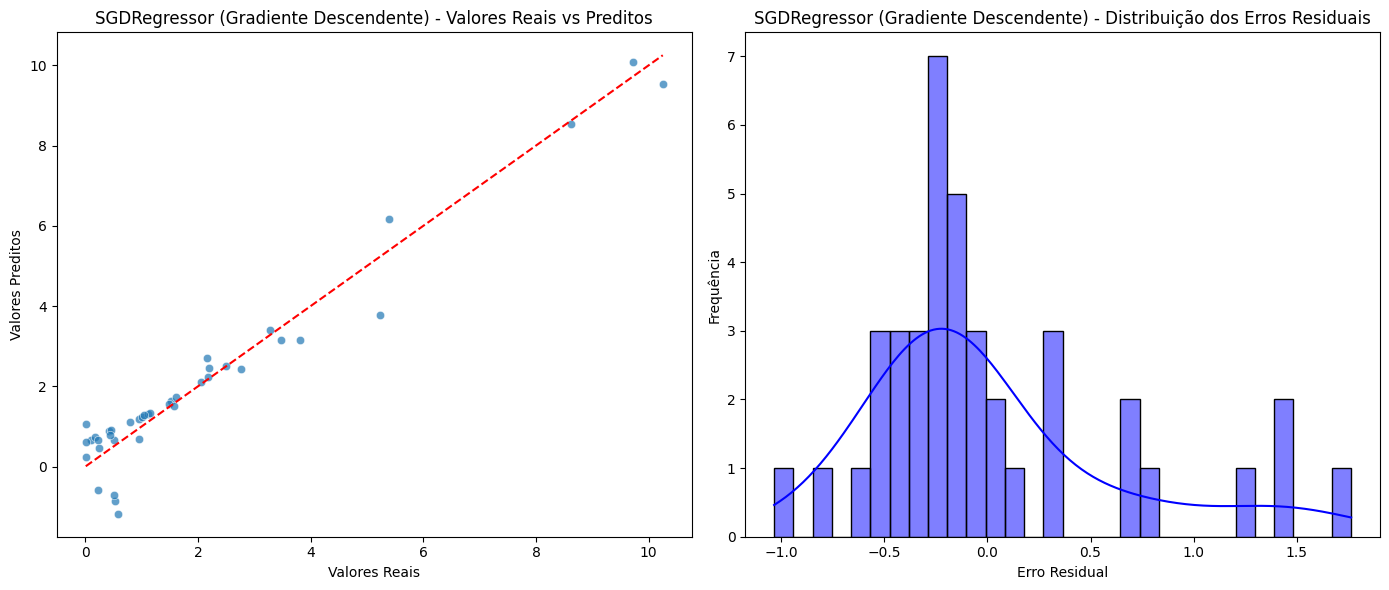


Modelo: Lasso (L1 Regularization)

Lasso (L1 Regularization)
R² Score: 0.9575
MSE: 0.2695
MAE: 0.3755

Coeficientes do modelo:
followers: -1.3304
avg_likes: 0.2487
new_post_avg_like: 3.1049


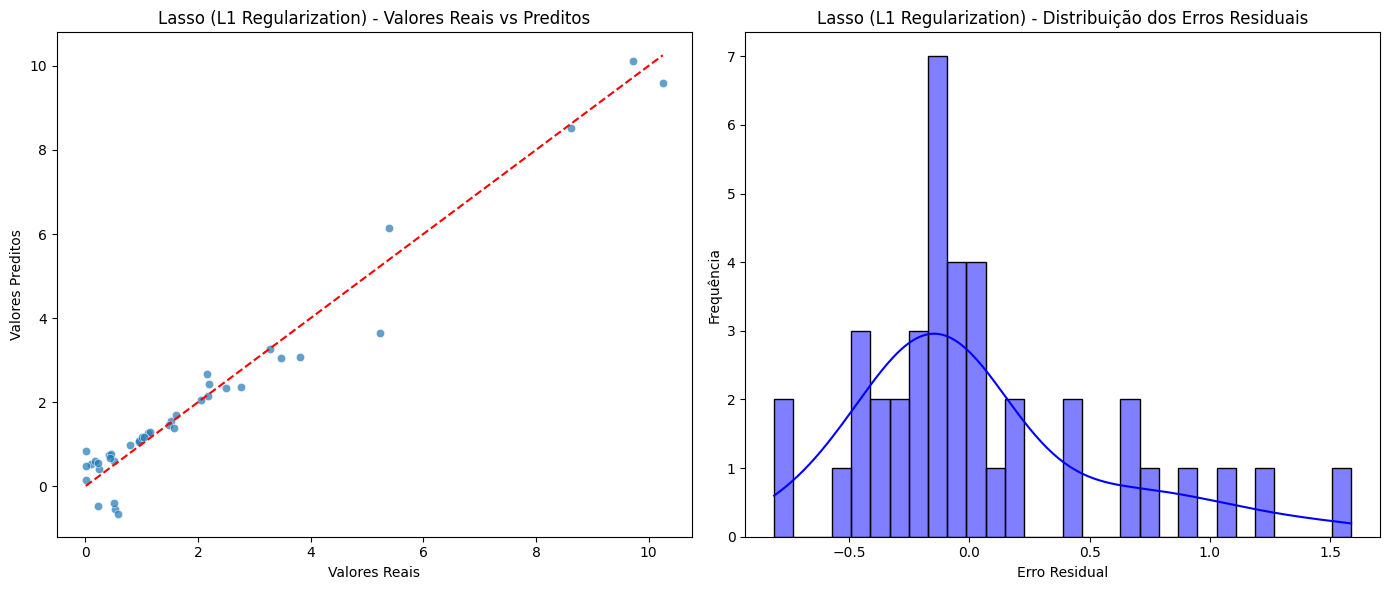


Modelo: Ridge (L2 Regularization)

Ridge (L2 Regularization)
R² Score: 0.9487
MSE: 0.3248
MAE: 0.3974

Coeficientes do modelo:
followers: -1.4867
avg_likes: 0.3561
new_post_avg_like: 3.1616


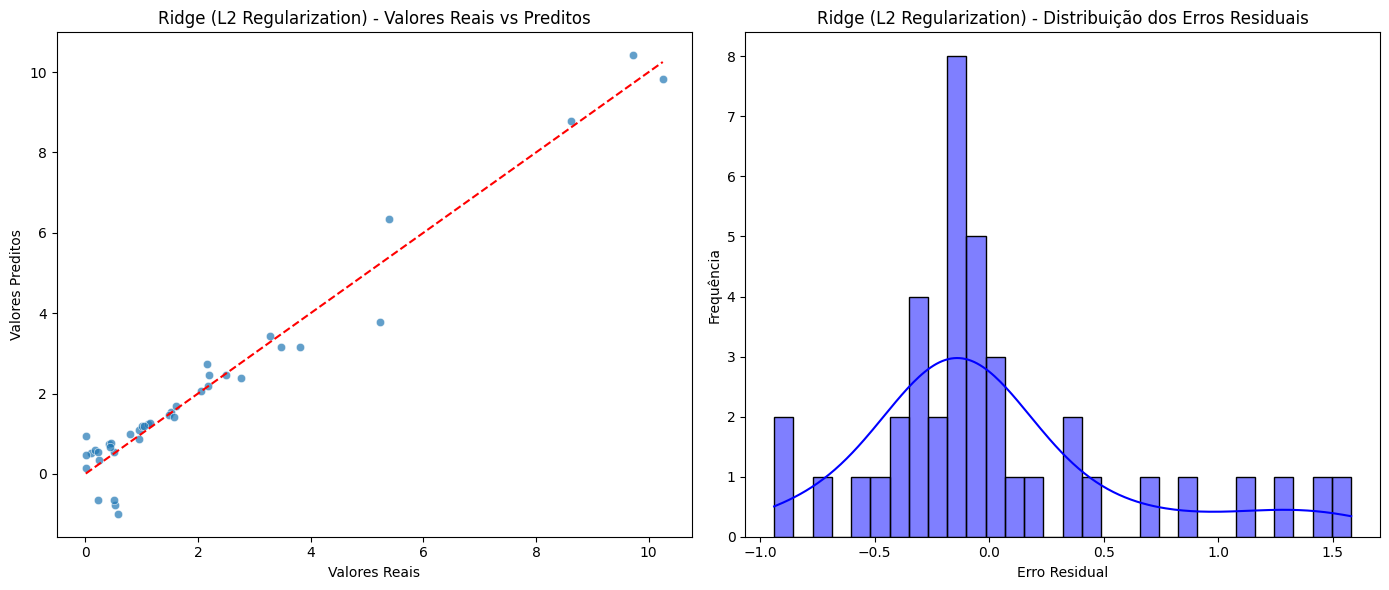


Modelo: Linear Regression com Seleção de Recursos

Linear Regression com Seleção de Recursos
R² Score: 0.9010
MSE: 0.6274
MAE: 0.5267

Coeficientes do modelo:
followers: -0.1123
avg_likes: 3.0819


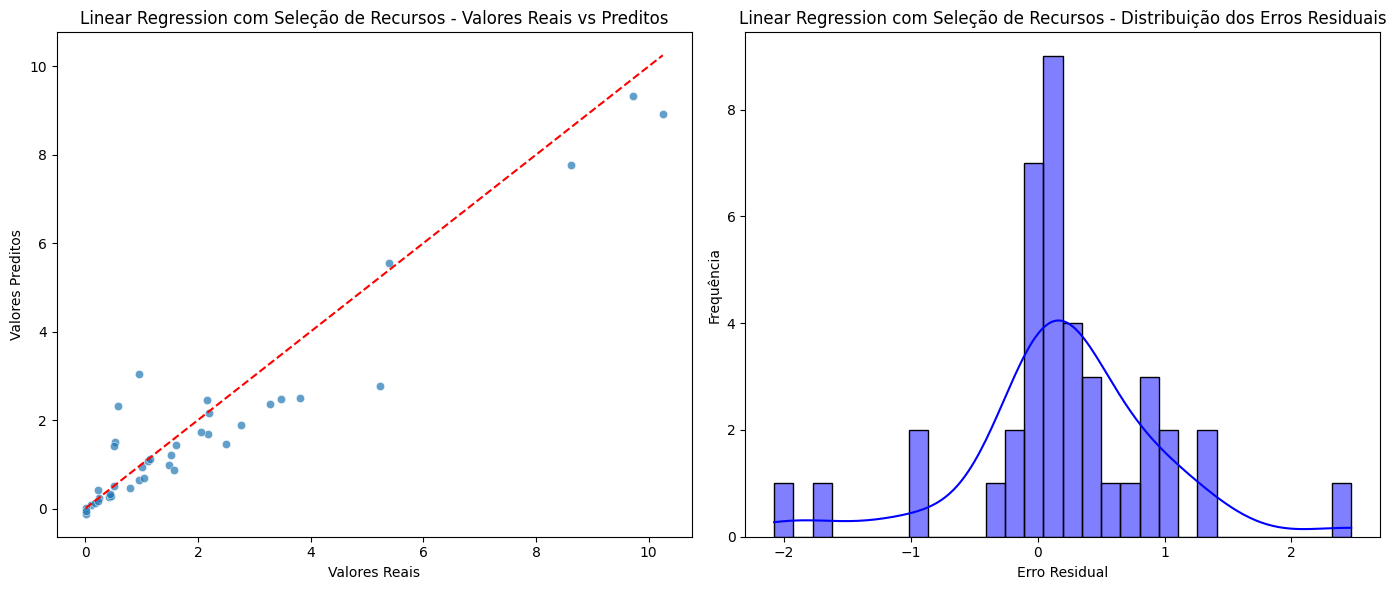


Comparação de Modelos com Validação Cruzada:
SGDRegressor - R² Score médio (Validação Cruzada): 0.8033 ± 0.0749
Lasso - R² Score médio (Validação Cruzada): 0.8412 ± 0.0461
Ridge - R² Score médio (Validação Cruzada): 0.8316 ± 0.0687
Linear Regression com Seleção de Recursos - R² Score médio (Validação Cruzada): 0.8315 ± 0.0692


In [1]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import SGDRegressor, LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression



# Caminho para o arquivo CSV
file_path = 'https://raw.githubusercontent.com/VeectorVt/predicao-engajamento/refs/heads/main/top_insta_influencers_data.csv'

# Carregar os dados
data = pd.read_csv(file_path)
data.head()

# Tratamento de valores ausentes para '60_day_eng_rate'
# Remover '%' e converter para float
data['60_day_eng_rate'] = data['60_day_eng_rate'].str.rstrip('%').astype(float)

# Preencher valores ausentes com a média da coluna
data['60_day_eng_rate'].fillna(data['60_day_eng_rate'].mean(), inplace=True)

# Definir a variável dependente
y = data['60_day_eng_rate']

# Função para converter strings com 'k', 'm', '%' para valores numéricos
def convert_to_numeric(value):
    if isinstance(value, str):
        value = value.lower()
        if 'k' in value:
            return float(value.replace('k', '')) * 1e3
        elif 'm' in value:
            return float(value.replace('m', '')) * 1e6
        elif 'b' in value:
            return float(value.replace('b', '')) * 1e9
    return value

# Converter as colunas de interesse para numéricas
data['posts'] = data['posts'].apply(convert_to_numeric)
data['followers'] = data['followers'].apply(convert_to_numeric)
data['avg_likes'] = data['avg_likes'].apply(convert_to_numeric)
data['new_post_avg_like'] = data['new_post_avg_like'].apply(convert_to_numeric)
data['total_likes'] = data['total_likes'].apply(convert_to_numeric)

# Seleção das variáveis independentes
X = data[['followers', 'avg_likes', 'new_post_avg_like']]

# Análise Exploratória com Visualizações
sns.pairplot(data[['followers', 'avg_likes', 'new_post_avg_like', '60_day_eng_rate']])
plt.show()

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Configuração de Validação Cruzada
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Função de Avaliação e Visualização
def evaluate_and_visualize(model, X_train, y_train, X_test, y_test, model_name):
    # Treinamento e Previsões
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Cálculo das métricas
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"\n{model_name}")
    print(f"R² Score: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

    # Interpretação dos Coeficientes (apenas para modelos com coeficientes)
    if hasattr(model, 'coef_'):
        print("\nCoeficientes do modelo:")
        for feature, coef in zip(X.columns, model.coef_):
            print(f"{feature}: {coef:.4f}")

    # Visualização Gráfica
    plt.figure(figsize=(14, 6))

    # Gráfico de dispersão: valores reais vs preditos
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
    plt.xlabel("Valores Reais")
    plt.ylabel("Valores Preditos")
    plt.title(f"{model_name} - Valores Reais vs Preditos")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # linha de ideal

    # Gráfico de erro residual
    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred
    sns.histplot(residuals, kde=True, color='blue', bins=30)
    plt.xlabel("Erro Residual")
    plt.ylabel("Frequência")
    plt.title(f"{model_name} - Distribuição dos Erros Residuais")

    plt.tight_layout()
    plt.show()

# Modelos e Avaliações
print("Modelo: SGDRegressor (Gradiente Descendente)")
sgd_model = SGDRegressor(learning_rate='constant', eta0=0.01, max_iter=1000)
evaluate_and_visualize(sgd_model, X_train_scaled, y_train, X_test_scaled, y_test, "SGDRegressor (Gradiente Descendente)")

print("\nModelo: Lasso (L1 Regularization)")
lasso_model = Lasso(alpha=0.1)
evaluate_and_visualize(lasso_model, X_train_scaled, y_train, X_test_scaled, y_test, "Lasso (L1 Regularization)")

print("\nModelo: Ridge (L2 Regularization)")
ridge_model = Ridge(alpha=0.1)
evaluate_and_visualize(ridge_model, X_train_scaled, y_train, X_test_scaled, y_test, "Ridge (L2 Regularization)")

# Seleção de Recursos (Top 2 mais correlacionadas)
selector = SelectKBest(score_func=f_regression, k=2)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

print("\nModelo: Linear Regression com Seleção de Recursos")
linear_model = LinearRegression()
evaluate_and_visualize(linear_model, X_train_selected, y_train, X_test_selected, y_test, "Linear Regression com Seleção de Recursos")

# Comparação de Modelos com Validação Cruzada
models = {
    "SGDRegressor": sgd_model,
    "Lasso": lasso_model,
    "Ridge": ridge_model,
    "Linear Regression com Seleção de Recursos": linear_model
}

print("\nComparação de Modelos com Validação Cruzada:")
for model_name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring='r2')
    print(f"{model_name} - R² Score médio (Validação Cruzada): {scores.mean():.4f} ± {scores.std():.4f}")